In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Constants
GRID_SIZE = 20
OBSTACLE = -1
DIRTY = 1
CLEAN = 0
CHARGING_STATION = 2
TIME_TUNNEL = 3
ROBOT = 4
HUMAN = 3
HAZARD = 6
MAX_BATTERY = 100
MIN_BATTERY = 0
DISCOUNT = 0.8

# List of possible actions
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'UP_LEFT', 'UP_RIGHT', 'DOWN_LEFT', 'DOWN_RIGHT', 'STAY']
# Dictionary mapping Action to corresponding change in Grid
ACTION_DELTA = {
    'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1),
    'UP_LEFT': (-1, -1), 'UP_RIGHT': (-1, 1), 'DOWN_LEFT': (1, -1), 'DOWN_RIGHT': (1, 1),
    'STAY': (0, 0)
}
# Each action has multiple possible outcomes, each associated with a probability : (probability, (row_change, col_change))
STOCHASTIC_TRANSITIONS = {
    'UP': [(0.8, (-1, 0)), (0.1, (-1, 1)), (0.1, (-1, -1))],
    'DOWN': [(0.8, (1, 0)), (0.1, (1, 1)), (0.1, (1, -1))],
    'LEFT': [(0.8, (0, -1)), (0.1, (-1, -1)), (0.1, (1, -1))],
    'RIGHT': [(0.8, (0, 1)), (0.1, (-1, 1)), (0.1, (1, 1))],
    'UP_LEFT': [(0.8, (-1, -1)), (0.1, (-1, -2)), (0.1, (-2, -1))],
    'UP_RIGHT': [(0.8, (-1, 1)), (0.1, (-1, 2)), (0.1, (-2, 1))],
    'DOWN_LEFT': [(0.8, (1, -1)), (0.1, (1, -2)), (0.1, (2, -1))],
    'DOWN_RIGHT': [(0.8, (1, 1)), (0.1, (1, 2)), (0.1, (2, 1))],
    'STAY': [(1.0, (0, 0))]
}

np.random.seed(42)
random.seed(42)

def init_complex_environment():
    """Initialize a complex environment with fixed elements."""
    grid = np.full((GRID_SIZE, GRID_SIZE), CLEAN)  # All cells are initially clean

    # Randomly set some cells as dirty
    dirty_spots = np.random.choice([DIRTY, CLEAN], size=(GRID_SIZE, GRID_SIZE), p=[0.2, 0.8])
    grid = np.where(dirty_spots == DIRTY, DIRTY, CLEAN)

    # Add static obstacles such as maze walls
    maze_walls = [(5, 5), (5, 6), (6, 5), (10, 10), (15, 15), (15, 14), (14, 15), (8, 8), (8, 9), (9, 8)]
    for wall in maze_walls:
        grid[wall] = OBSTACLE

    # Add charging stations
    grid[0, 0] = CHARGING_STATION
    grid[GRID_SIZE - 1, 0] = CHARGING_STATION
    grid[0, GRID_SIZE - 1] = CHARGING_STATION
    grid[GRID_SIZE - 1, GRID_SIZE - 1] = CHARGING_STATION

    # Add multiple time tunnels
    grid[3, 3] = TIME_TUNNEL
    grid[17, 17] = TIME_TUNNEL
    grid[8, 2] = TIME_TUNNEL
    grid[15, 19] = TIME_TUNNEL

    return grid

def add_dynamic_elements(grid, num_humans=5, num_dynamic_obstacles=10, num_hazards=10):
    """Add dynamic elements like moving obstacles, humans, and hazards."""
    # Add humans
    for _ in range(num_humans):
        x, y = np.random.randint(0, GRID_SIZE, size=2)
        while grid[x, y] in [OBSTACLE, CHARGING_STATION, TIME_TUNNEL]:
            x, y = np.random.randint(0, GRID_SIZE, size=2)
        grid[x, y] = HUMAN

    # Add dynamic obstacles
    for _ in range(num_dynamic_obstacles):
        x, y = np.random.randint(0, GRID_SIZE, size=2)
        while grid[x, y] in [OBSTACLE, CHARGING_STATION, TIME_TUNNEL, HUMAN]:
            x, y = np.random.randint(0, GRID_SIZE, size=2)
        grid[x, y] = OBSTACLE

    # Add hazards
    for _ in range(num_hazards):
        x, y = np.random.randint(0, GRID_SIZE, size=2)
        while grid[x, y] in [OBSTACLE, CHARGING_STATION, TIME_TUNNEL, HUMAN]:
            x, y = np.random.randint(0, GRID_SIZE, size=2)
        grid[x, y] = HAZARD

def take_action(state, action, battery, grid):
    x, y = state
    next_state = state
    reward = -1  # Step penalty

    # Stochastic transitions
    if action in STOCHASTIC_TRANSITIONS:
        transitions = STOCHASTIC_TRANSITIONS[action]
        prob, (dx, dy) = random.choices(transitions, weights=[t[0] for t in transitions])[0]
        new_x, new_y = x + dx, y + dy

        if 0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE:
            next_state = (new_x, new_y)

    # Interactions with the grid
    if grid[next_state] == DIRTY:
        reward += 10  # Clean the dirty spot
        grid[next_state] = CLEAN  # Mark the cell as clean
    elif grid[next_state] == OBSTACLE:
        reward -= 10  # Penalty for hitting an obstacle
        return state, reward, True  # Episode ends if obstacle hit
    elif grid[next_state] == CHARGING_STATION:
        reward += 5  # Reward for reaching charging station
        battery = MAX_BATTERY  # Recharge
    elif grid[next_state] == TIME_TUNNEL:
        # Transport to a different location (time tunnel functionality)
        if next_state == (3, 3):
            next_state = (17, 17)
        elif next_state == (17, 17):
            next_state = (3, 3)
        elif next_state == (8, 2):
            next_state = (15, 19)
        elif next_state == (15, 19):
            next_state = (8, 2)
    elif grid[next_state] == HUMAN:
        reward -= 20  # Penalty for hitting a human
        return state, reward, True  # Episode ends if human hit
    elif grid[next_state] == HAZARD:
        reward -= 30  # Penalty for hitting a hazard
        return state, reward, True  # Episode ends if hazard hit

    battery -= 1
    if battery <= MIN_BATTERY:
        reward -= 10  # Extra penalty for low battery

    return next_state, reward, battery == 0  # Episode ends if battery runs out

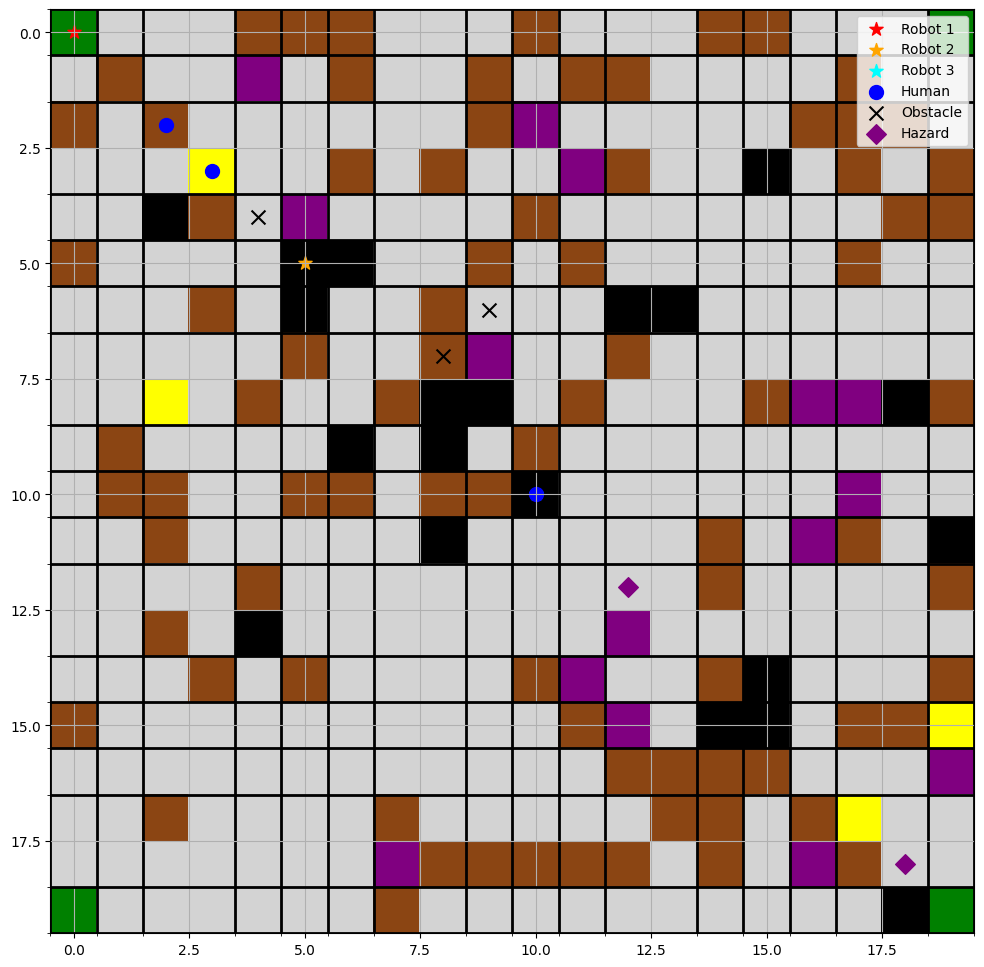

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Constants for labels and colors
LABELS = {
    CLEAN: 'Clean',
    DIRTY: 'Dirty',
    OBSTACLE: 'Obstacle',
    CHARGING_STATION: 'Charging Station',
    TIME_TUNNEL: 'Time Tunnel',
    HUMAN: 'Human',
    HAZARD: 'Hazard',
}

color_map = {
    CLEAN: 'lightgray',
    DIRTY: 'saddlebrown',
    OBSTACLE: 'black',
    CHARGING_STATION: 'green',
    TIME_TUNNEL: 'yellow',
    HUMAN: 'blue',
    HAZARD: 'purple',
}

def visualize_grid(grid, robot_positions, humans, obstacles, hazards):
    # Create a grid for the colors
    grid_colors = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for (i, j), value in np.ndenumerate(grid):
        grid_colors[i, j] = value

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 12))

    # Define a colormap based on color_map
    cmap = ListedColormap([color_map[v] for v in sorted(color_map.keys())])

    # Show the grid with colors
    cax = ax.imshow(grid_colors, cmap=cmap, vmin=min(color_map.keys()), vmax=max(color_map.keys()))

    # Plot each robot with a unique color
    robot_colors = ['red', 'orange', 'cyan', 'magenta']
    for idx, (robot_x, robot_y) in enumerate(robot_positions):
        ax.scatter(robot_y, robot_x, marker="*", color=robot_colors[idx % len(robot_colors)], s=100, label=f"Robot {idx + 1}")

    # Plot humans
    for hx, hy in humans:
        ax.scatter(hy, hx, marker="o", color="blue", s=100, label="Human")

    # Plot dynamic obstacles
    for ox, oy in obstacles:
        ax.scatter(oy, ox, marker="x", color="black", s=100, label="Obstacle")

    # Plot hazards
    for hx, hy in hazards:
        ax.scatter(hy, hx, marker="D", color="purple", s=100, label="Hazard")

    # Add grid lines
    ax.grid(True)
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    # Avoid duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')

    plt.show()

# Testing the environment initialization and visualization
grid = init_complex_environment()
add_dynamic_elements(grid)
robot_positions = [(0, 0), (5, 5), (10, 10)]  # Example of 3 robots
humans = [(2, 2), (3, 3), (10, 10)]
obstacles = [(7, 8), (6, 9), (4, 4)]
hazards = [(18, 18), (12, 12)]
visualize_grid(grid, robot_positions, humans, obstacles, hazards)


In [ ]:
from collections import defaultdict
import numpy as np
import random

class OnPolicyMonteCarlo:
    def __init__(self, grid, gamma=DISCOUNT, epsilon=0.9):
        self.grid = grid
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration probability
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
        self.policy = {}
        self.q_values = defaultdict(lambda: np.zeros(len(ACTIONS)))

        # Initialize policies for all possible states
        for state in self._get_all_states():
            self.policy[state] = random.choice(ACTIONS)

    def _get_all_states(self):
        """Return all possible states in the grid."""
        return [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]

    def generate_episode(self):
        """Generate an episode following the current policy."""
        episode = []
        state = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        battery = MAX_BATTERY
        done = False

        while not done and battery > 0:
            if random.uniform(0, 1) > self.epsilon:
                action = self.policy[state]
            else:
                action = random.choice(ACTIONS)
            next_state, reward, done = take_action(state, action, battery, self.grid)
            episode.append((state, action, reward))
            state = next_state
            battery -= 1

        return episode

    def update_policy(self):
        """Perform policy improvement using the results from generated episodes."""
        episode = self.generate_episode()
        G = 0
        visited_state_actions = set()  # To track visited (state, action) pairs in the current episode

        for (state, action, reward) in reversed(episode):
            G = self.gamma * G + reward
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))
                self.returns_sum[(state, action)] += G
                self.returns_count[(state, action)] += 1
                self.q_values[state][ACTIONS.index(action)] = (
                    self.returns_sum[(state, action)] / self.returns_count[(state, action)]
                )
                # Policy improvement
                self.policy[state] = ACTIONS[np.argmax(self.q_values[state])]

    def learn(self, episodes=1000):
        rewards = []  # List to store rewards for each episode
        plotted = False  # Flag to track if plots have been generated
        for episode in range(episodes):
            self.update_policy()
            # Evaluate the policy after each episode
            average_reward = evaluate_onpolicy(self, num_test_episodes=100)
            rewards.append(average_reward)
            if episode % 100 == 0: # Check convergence every 100 episodes
                if np.mean(rewards[-100:]) - np.mean(rewards[-200:-100]) < 0.1 and not plotted: # Convergence condition
                    plt.plot(rewards)
                    plt.xlabel('Episodes')
                    plt.ylabel('Average Reward')
                    plt.title('On-Policy Monte Carlo Convergence')
                    plt.show()
                    plotted = True

    def get_action_from_policy(self, state):
        """Get action from the current policy."""
        return self.policy[state]

In [ ]:
def evaluate_onpolicy(mc, num_test_episodes=100):
    """Evaluate the learned policy by running multiple test episodes."""
    total_reward = 0

    for _ in range(num_test_episodes):
        state = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        battery = MAX_BATTERY
        done = False
        episode_reward = 0

        while not done and battery > 0:
            action = mc.policy[state]  # Directly use the policy attribute
            next_state, reward, done = take_action(state, action, battery, mc.grid)
            episode_reward += reward
            state = next_state
            battery -= 1

        total_reward += episode_reward

    average_reward = total_reward / num_test_episodes
    return average_reward

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_policy_and_q_values_onpolicy(mc):
    """Visualize the learned policy and Q-values."""
    # Create a grid for the colors
    q_value_grid = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))  # 3D grid for Q-values

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            state = (i, j)
            if state in mc.q_values:
                q_value_grid[i, j] = mc.q_values[state]

    # Number of actions
    num_actions = len(ACTIONS)

    # Create figure with subplots for Q-values and one for the grid
    fig, axes = plt.subplots(4, 3, figsize=(20, 24))

    # Plot Q-values for each action
    for idx, action in enumerate(ACTIONS):
        row = (idx) // 3  # Calculate row index
        col = (idx) % 3   # Calculate column index
        ax = axes[row, col]
        cax = ax.imshow(q_value_grid[:, :, idx], cmap='viridis')
        ax.set_title(f"Q-values for {action}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, which='minor', linestyle='--', linewidth=0.5)
        fig.colorbar(cax, ax=ax, orientation='vertical')

    # Hide any empty subplots
    for ax in axes.flatten()[num_actions:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


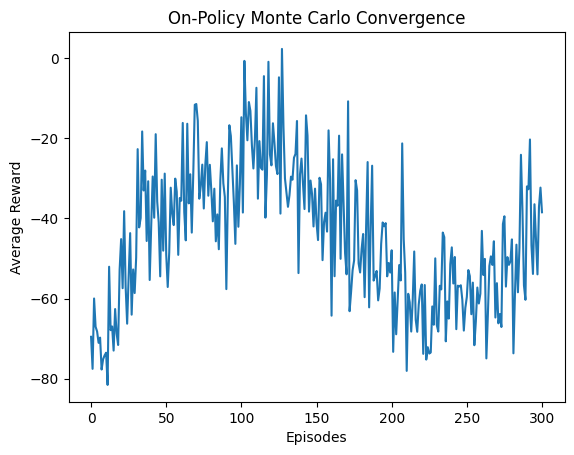

Average Reward: -53.08


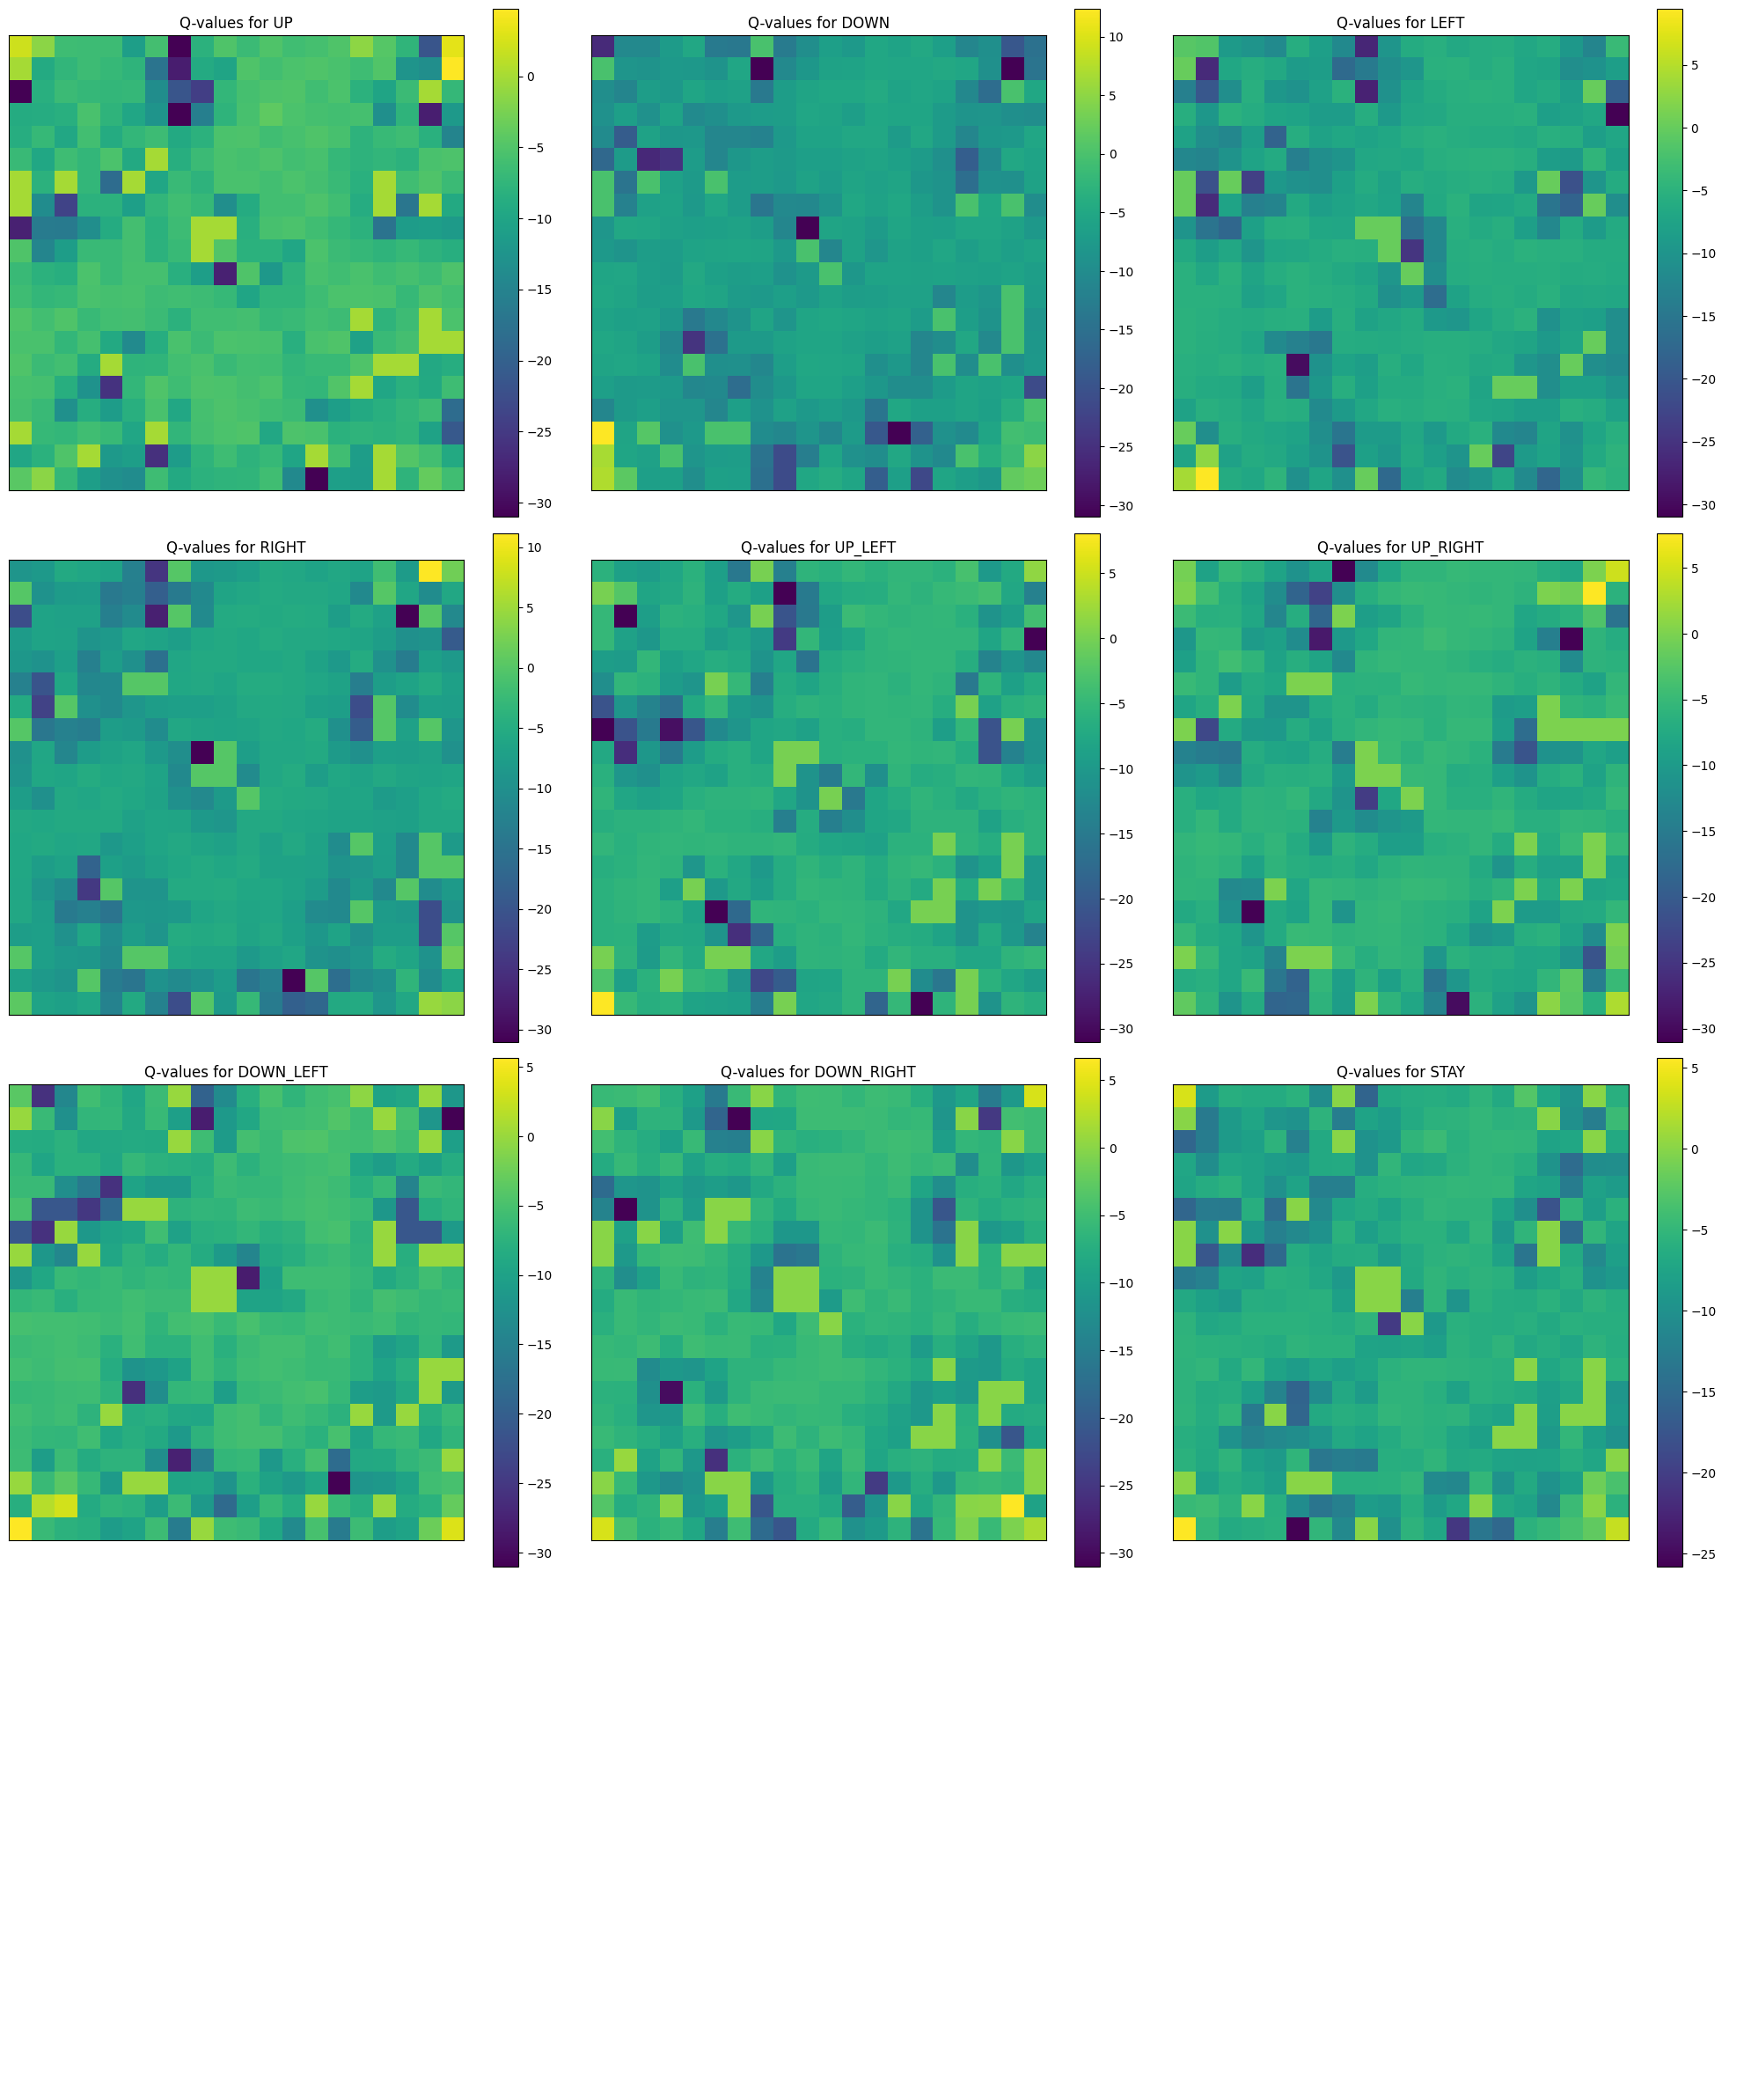

In [ ]:
grid = init_complex_environment()
add_dynamic_elements(grid)
opmc = OnPolicyMonteCarlo(grid)
opmc.learn(episodes=1000)

# Evaluate the learned policy
average_reward = evaluate_onpolicy(opmc, num_test_episodes=100)
print(f"Average Reward: {average_reward}")

# Visualize the learned policy and Q-values
visualize_policy_and_q_values_onpolicy(opmc)

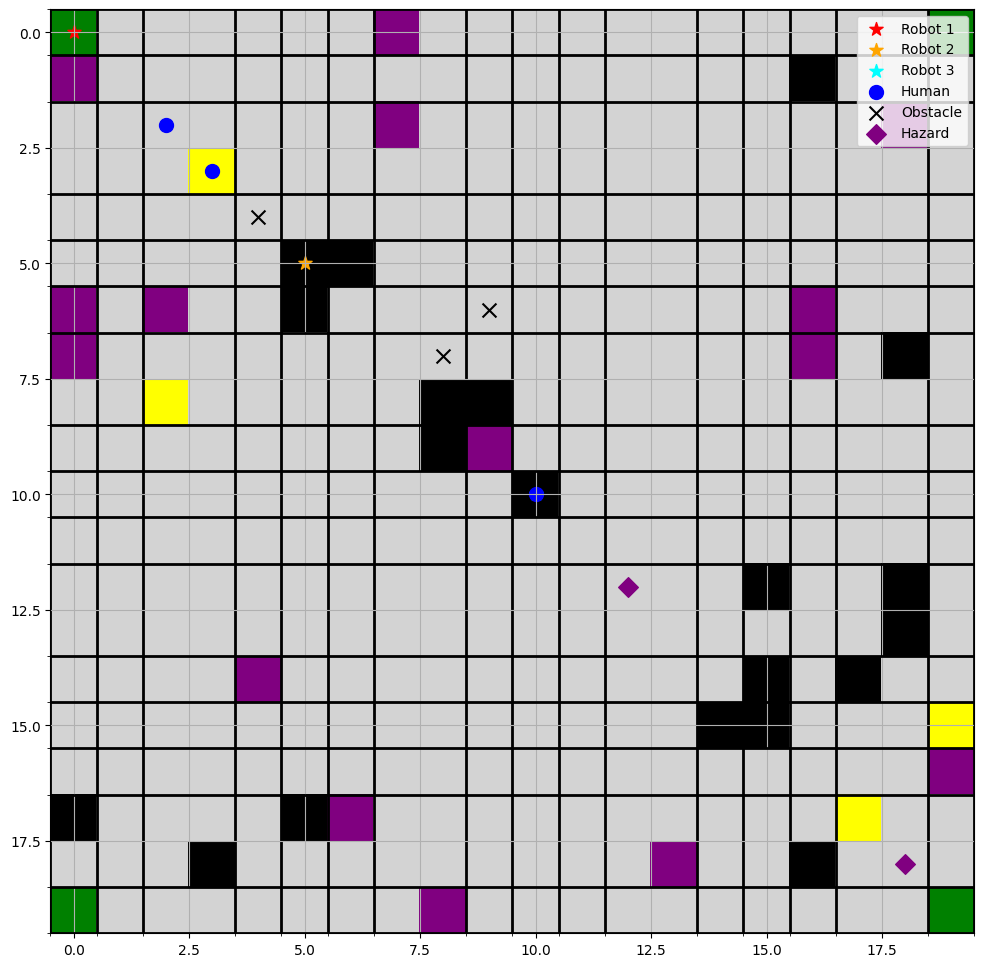

In [ ]:
visualize_grid(grid, robot_positions, humans, obstacles, hazards)

In [ ]:
class OffPolicyMonteCarlo:
    def __init__(self, grid, gamma=DISCOUNT, epsilon=0.1, behavior_epsilon=0.9):
        self.grid = grid
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Epsilon for the target policy
        self.behavior_epsilon = behavior_epsilon  # Epsilon for the behavior policy
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
        self.q_values = defaultdict(lambda: np.zeros(len(ACTIONS)))

        # Initialize target policy with low epsilon (more greedy)
        self.policy = {}

        # Initialize behavior policy with higher epsilon (more exploratory)
        self.behavior_policy = {}

        # Initialize policies for all states
        for state in self._get_all_states():
            self.policy[state] = self._initialize_target_policy(state)
            self.behavior_policy[state] = self._initialize_behavior_policy(state)

    def _get_all_states(self):
        """Return all possible states in the grid."""
        return [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]

    def _initialize_target_policy(self, state):
        """Initialize the target policy with epsilon-greedy approach."""
        return random.choice(ACTIONS) if random.uniform(0, 1) < self.epsilon else self._greedy_action(state)

    def _initialize_behavior_policy(self, state):
        """Initialize the behavior policy with higher epsilon for exploration."""
        return random.choice(ACTIONS) if random.uniform(0, 1) < self.behavior_epsilon else self._greedy_action(state)

    def _greedy_action(self, state):
        """Select the action with the highest Q-value for the target policy."""
        if state not in self.q_values:
            return random.choice(ACTIONS)  # If no Q-values are known, choose randomly
        return ACTIONS[np.argmax(self.q_values[state])]

    def generate_episode(self):
        """Generate an episode following the behavior policy."""
        episode = []
        state = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        battery = MAX_BATTERY
        done = False

        while not done and battery > 0:
            # Use the behavior_policy dictionary to get the action, ensuring state is passed
            if random.uniform(0, 1) > self.behavior_epsilon:
                action = self.behavior_policy[state]
            else:
                action = random.choice(ACTIONS)
            next_state, reward, done = take_action(state, action, battery, self.grid)
            episode.append((state, action, reward))
            state = next_state
            battery -= 1

        return episode

    def update_policy(self):
        """Perform policy improvement using the results from generated episodes."""
        episode = self.generate_episode()
        G = 0
        W = 1  # Importance sampling ratio
        visited_state_actions = set()  # To track visited (state, action) pairs in the current episode

        for (state, action, reward) in reversed(episode):
            G = self.gamma * G + reward
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))

                # Calculate probability of action under behavior policy
                behavior_prob = (self.behavior_epsilon / len(ACTIONS)) if self.behavior_policy[state] != action else (1 - self.behavior_epsilon + (self.behavior_epsilon / len(ACTIONS)))

                # Avoid division by zero
                if behavior_prob > 0:
                    W *= (1 / behavior_prob)

                # Update returns sum and count for importance sampling
                self.returns_sum[(state, action)] += W * G
                self.returns_count[(state, action)] += W

                # Update Q-values
                self.q_values[state][ACTIONS.index(action)] = (
                    self.returns_sum[(state, action)] / self.returns_count[(state, action)]
                )

                # Policy improvement for the target policy
                self.policy[state] = ACTIONS[np.argmax(self.q_values[state])]

    def learn(self, episodes=1000):
        rewards = []  # List to store rewards for each episode
        plotted = False  # Flag to track if plots have been generated
        for episode in range(episodes):
            self.update_policy()
            # Evaluate the policy after each episode
            average_reward = evaluate_offpolicy(self, num_test_episodes=100)
            rewards.append(average_reward)
            if episode % 100 == 0: # Check convergence every 100 episodes
                if np.mean(rewards[-100:]) - np.mean(rewards[-200:-100]) < 0.1 and not plotted: # Convergence condition
                    plt.plot(rewards)
                    plt.xlabel('Episodes')
                    plt.ylabel('Average Reward')
                    plt.title('Off-Policy Monte Carlo Convergence')
                    plt.show()
                    plotted = True

    def get_action_from_policy(self, state):
        """Get action from the target policy."""
        return self.policy[state]

In [ ]:
def evaluate_offpolicy(mc, num_test_episodes=100):
    """Evaluate the learned target policy by running multiple test episodes."""
    total_reward = 0

    for _ in range(num_test_episodes):
        state = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        battery = MAX_BATTERY
        done = False
        episode_reward = 0

        while not done and battery > 0:
            action = mc.get_action_from_policy(state)  # Use the target policy
            next_state, reward, done = take_action(state, action, battery, mc.grid)
            episode_reward += reward
            state = next_state
            battery -= 1

        total_reward += episode_reward

    average_reward = total_reward / num_test_episodes
    return average_reward


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_policy_and_q_values_offpolicy(mc):
    """Visualize the learned policy and Q-values."""
    # Create a grid for the colors
    q_value_grid = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))  # 3D grid for Q-values

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            state = (i, j)
            if state in mc.q_values:
                q_value_grid[i, j] = mc.q_values[state]

    # Number of actions
    num_actions = len(ACTIONS)

    # Create figure with subplots for Q-values and one for the grid
    fig, axes = plt.subplots(4, 3, figsize=(20, 24))

    # Plot Q-values for each action
    for idx, action in enumerate(ACTIONS):
        row = (idx) // 3  # Calculate row index
        col = (idx) % 3   # Calculate column index
        ax = axes[row, col]
        cax = ax.imshow(q_value_grid[:, :, idx], cmap='viridis')
        ax.set_title(f"Q-values for {action}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, which='minor', linestyle='--', linewidth=0.5)
        fig.colorbar(cax, ax=ax, orientation='vertical')

        # Hide any empty subplots
    for ax in axes.flatten()[num_actions:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

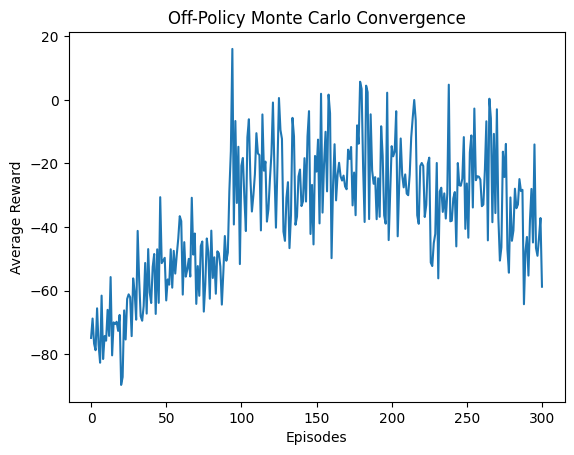

Average Reward: -12.92


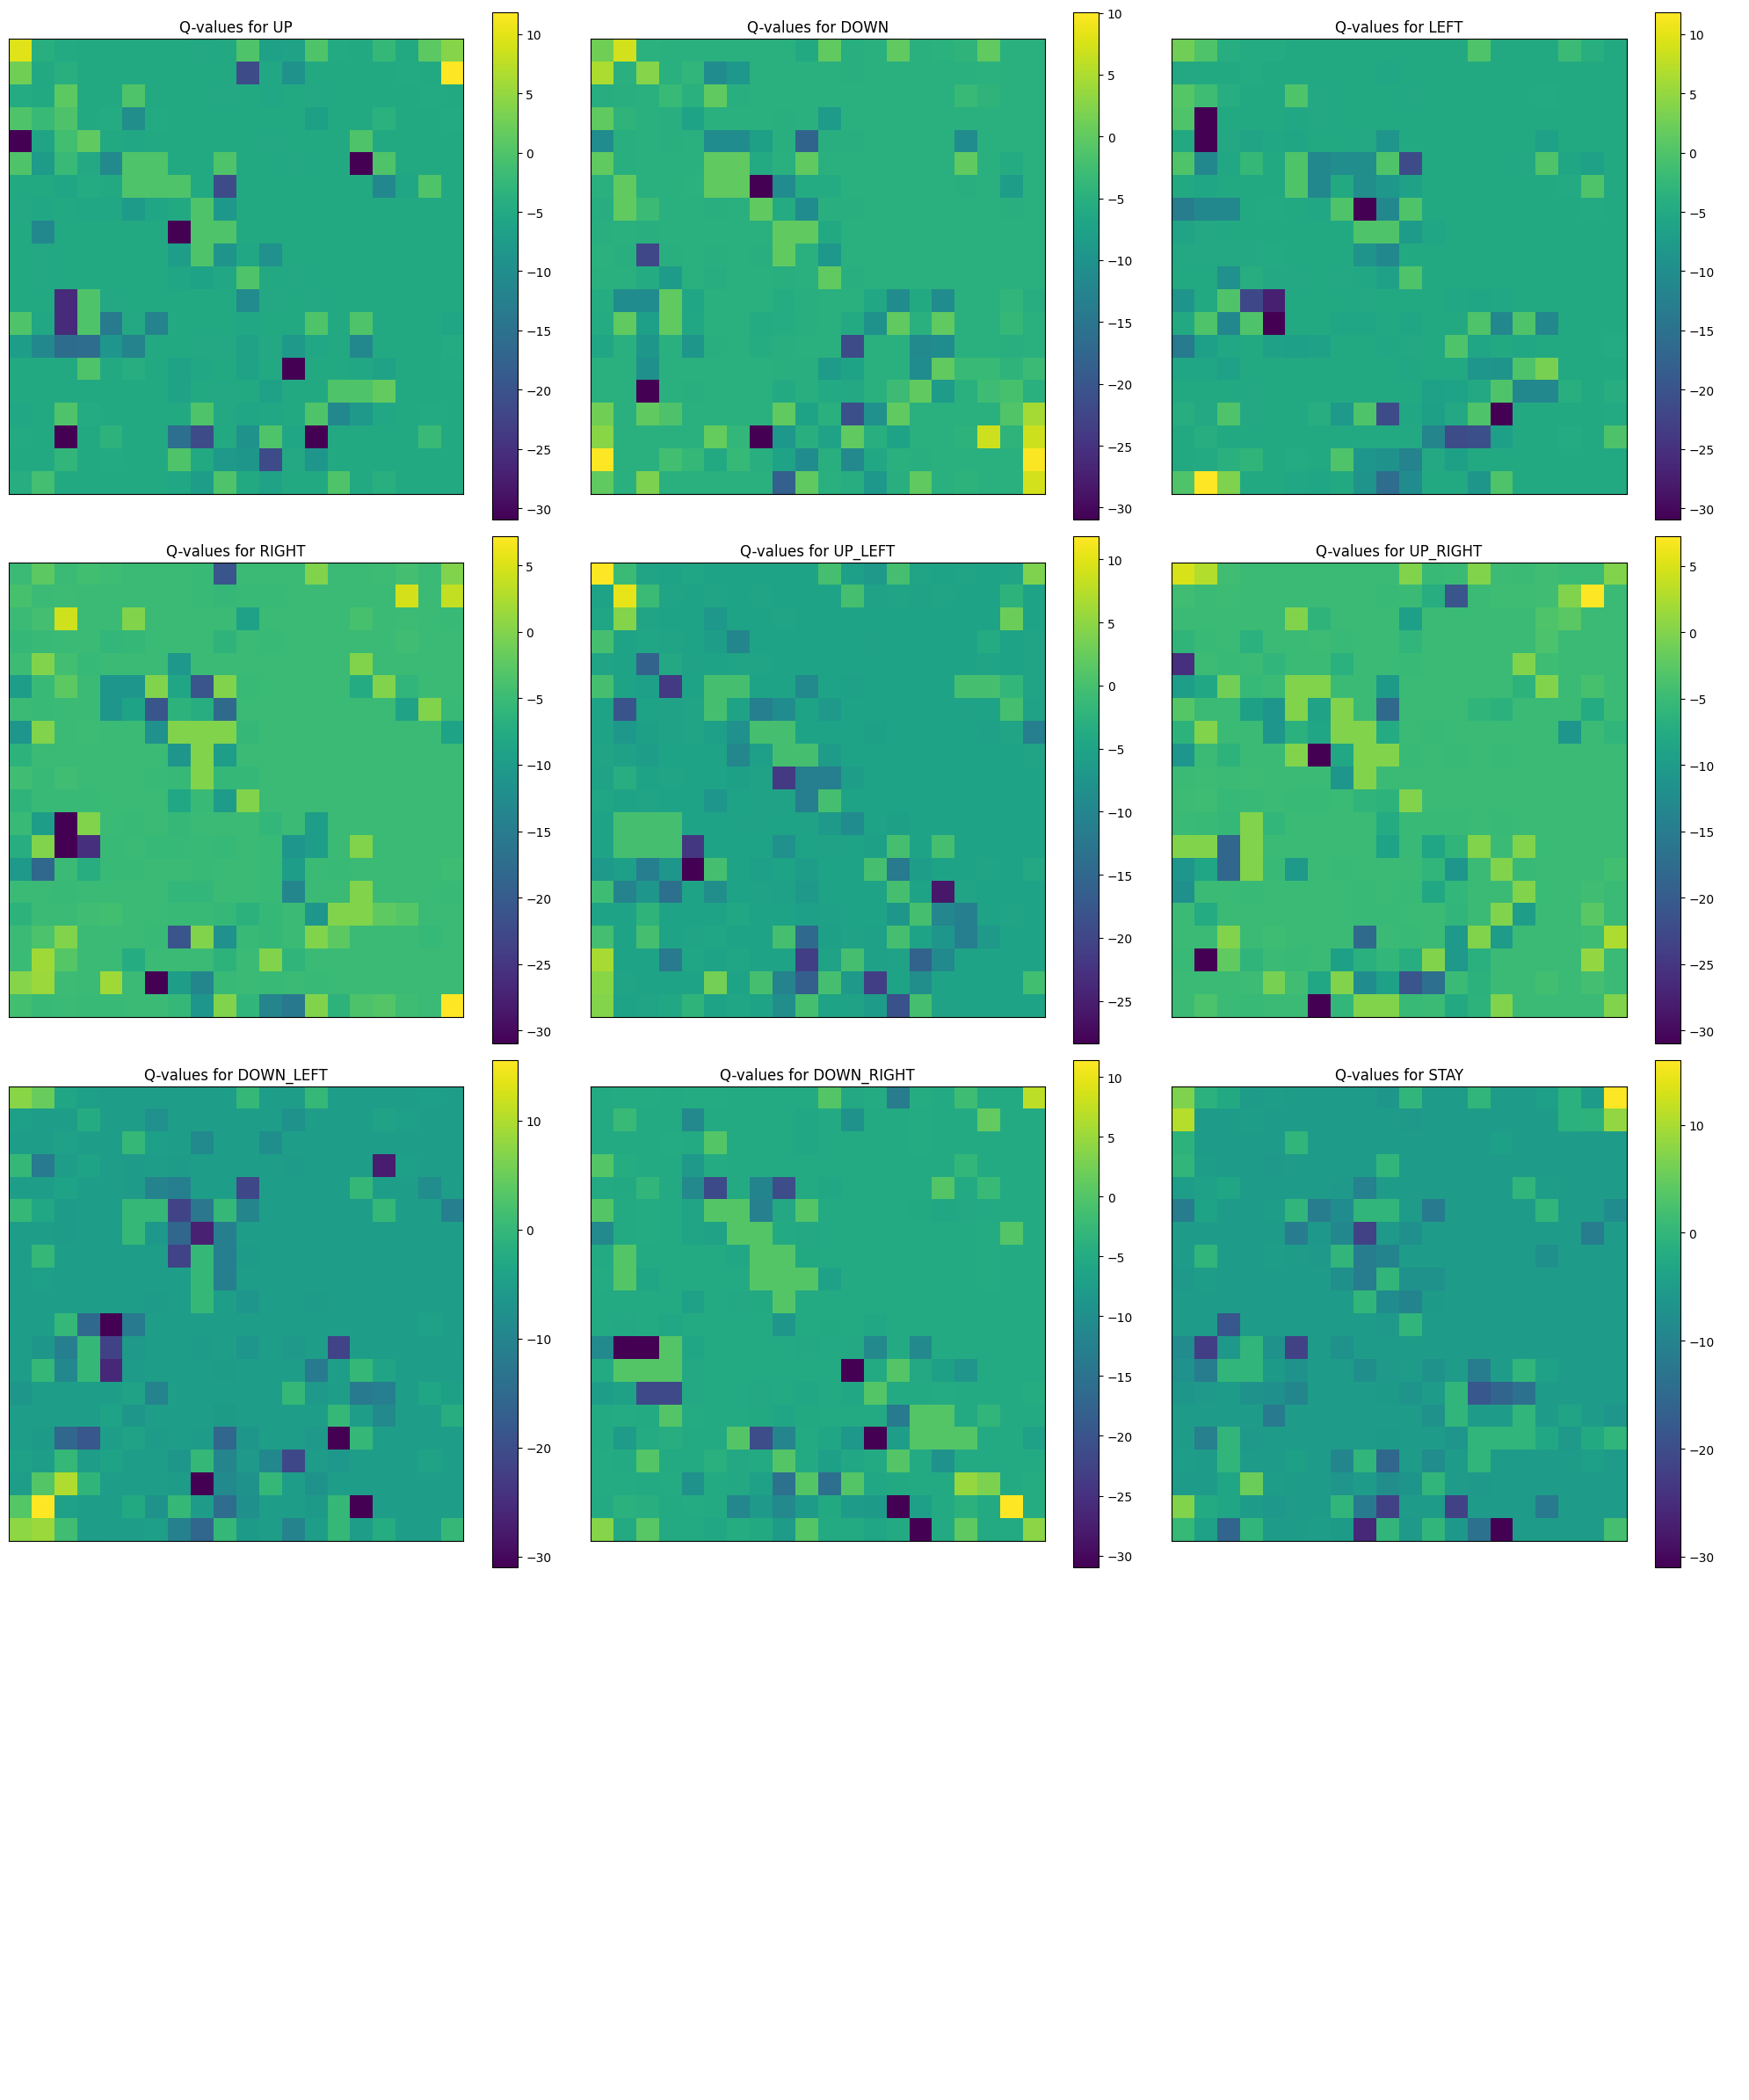

In [ ]:
grid = init_complex_environment()
add_dynamic_elements(grid)
ofmc = OffPolicyMonteCarlo(grid)
ofmc.learn(episodes=1000)

# Evaluate the learned policy
average_reward = evaluate_offpolicy(ofmc, num_test_episodes=100)
print(f"Average Reward: {average_reward}")

# Visualize the learned policy and Q-values
visualize_policy_and_q_values_offpolicy(ofmc)

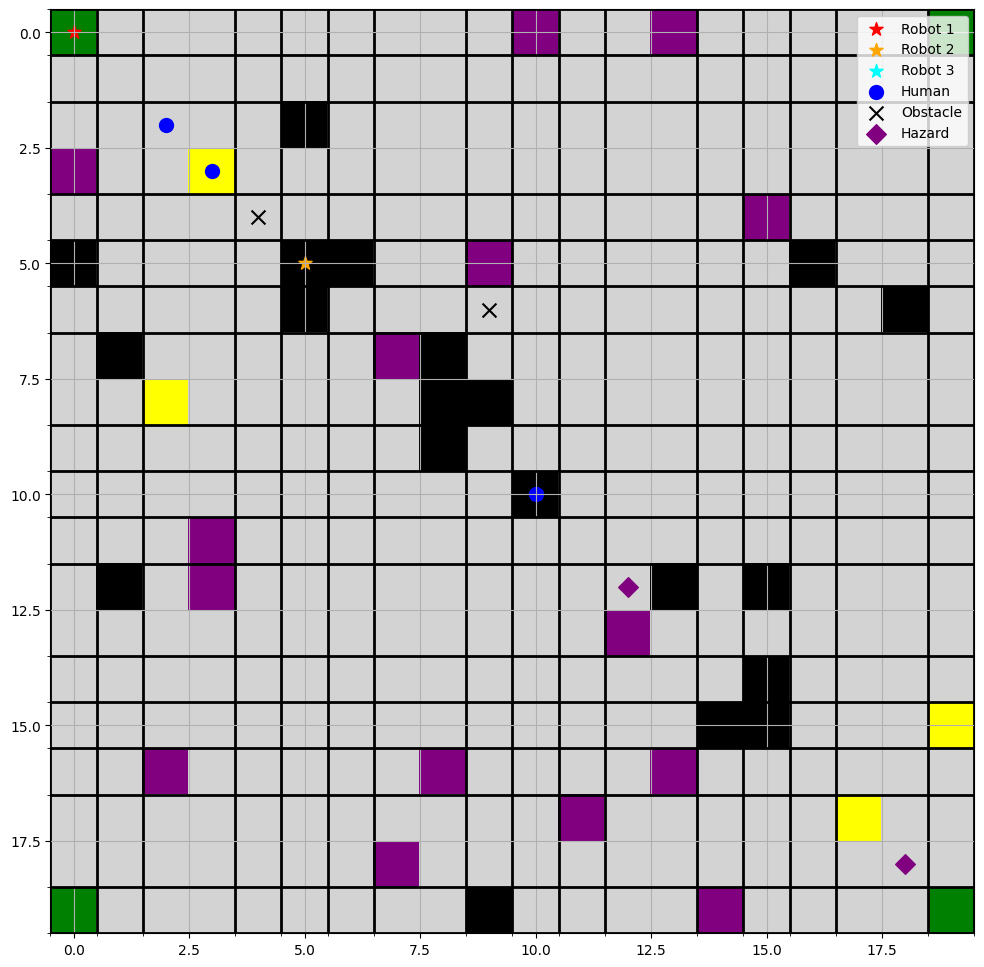

In [ ]:
visualize_grid(grid, robot_positions, humans, obstacles, hazards)